# **Лабораторная работа №4**

*Параллельный алгоритм размытия изображения на CUDA*

### Задача 

Размыть изображение при помощи фильтра Гаусса с использованием средств распараллеливания CUDA. 

Общее описание алгоритма: изображение размеров NxM может быть представлено в формате RGB, где каждый пиксель – число от 0 до 255. Требуется создать фильтр размытия, представленный в виде свёрточной матрицы, заполненной в соответствии с Гауссовским распределением в двумере (сигму можно сделать параметром). От размера матрицы зависит степень размытия, для теста использовалась матрица 3x3. Можно так же сделать это параметром и поэкспериментировать с различными размерностями. Можно использовать уже известные матрицы свёртки. Затем данный фильтр применяется для каждого пикселя исходного изображения, результат суммируется и записывается в пиксель выходного массива. 

Для работы с краями можно почитать [в этой статье](https://habr.com/ru/post/142818/), там же есть вполне подробное описание алгоритма и даны примеры свёрточных матриц. В результате все три канала формируют изображение. Можно воспользоваться любой библиотекой для этого (во вложении питоновский ноутбук преобразования изображения в RGB, можете его переписать под нормальный вывод RGB массивов). CUDA достаточно использовать для непосредственно размытия изображения, для предпроцессинга и постпроцессинга RGB каналов ниже описаны специальные функции.

Альтернатива: для тех кому совсем не хочется разбираться с изображениями, можно реализовать алгоритм свёртки матрицы и протестировать его на CUDA для различных размерностей, оценка за это будет соответственно ниже

Содержание отчёта: сравнить время работы алгоритма свёртки или полного метода размытия для различных размерностей матрицы/картинки с CUDA и без, привести пример размытого изображения. Для тестов можно использовать приложенные матрицы и изображения, размытое изображение было получено не программно, так что возможно не точное совпадение при проверке. **Отчет и программу следует писать в этом ноутбуке.** По результату запуска всех секций в ноутбуке, должны выводиться полученные картинки и графики. Если Вам необходимо отправить вместе с ноутбуком дополнительные файлы - отправить их архивом вместе с этим ноутбуком.

Критерии оценивания: 
* 4 балла – алгоритм свёртки для матрицы
* 4 балла – полный метод размытия
* 2 балла – отчёт


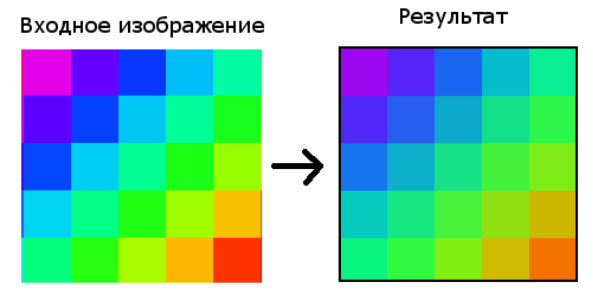

### Environment

Библиотека для отображения изображений в ноутбуке.

In [1]:
! pip install ipyplot

Подключаем CUDA (не забудьте сменить среду выполнения на GPU): 

In [2]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-8pvle398
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-8pvle398
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4308 sha256=8ac85f209bc37519e931b6704bce7e81966f45b4e0ced1352443969df79a6656
  Stored in directory: /tmp/pip-ephem-wheel-cache-_o3u64rl/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
directory /content/src already exists
Out bin /content/result.out


### Utilities

Функция ```save_as_text``` преобразует изображение в текстовый файл в следующем формате: 
* в первой строке описаны ширина и высота в пикселях, а также количество каналов картинки
* в последующих строках идут три матрицы для красного, зеленого и синего (RGB) цвета соответствующего размера

Функция ```load_from_text``` преобразует файл вышеописанного формата обратно в RGB изображение.

In [3]:
from itertools import product

import numpy as np

from PIL import Image


RGB_MODE = "RGB"


def get_image_width(path: str) -> int:
    image = Image.open(path)
    image = image.convert(RGB_MODE)
    width, height, channels = np.shape(image)
    return width


def get_pixels_in_image(path: str) -> int:
    image = Image.open(path)
    image = image.convert(RGB_MODE)
    width, height, channels = np.shape(image)
    return width * height


def save_as_text(path_to_image: str, path_to_text: str) -> None:
    image = Image.open(path_to_image)
    image = image.convert(RGB_MODE)
    width, height, channels = np.shape(image)

    A = []
    for coordinates in product(range(height), range(width)):
        A.append(image.getpixel(coordinates))
    A = np.array(A)

    with open(path_to_text, "w") as f:
        f.write(f"{width} {height} {channels}\n")

        for channel in range(channels):
            B = A[:, channel].reshape(height, width)

            for x in range(height):
                for y in range(width):
                    f.write(f"{B[x, y]} ")
                f.write("\n")


def load_from_text(path_to_text: str, path_to_image: str) -> None:
    with open(path_to_text, "r") as f:
        width, height, channels = map(int, f.readline().split())

        A = []
        for channel in range(channels):
            B = []
            for h in range(height):
                B.append(list(map(np.uint8, f.readline().split())))
            A.append(B)

        # width, height, channels
        A = np.array(A).transpose((2, 1, 0))

    image = Image.fromarray(A, RGB_MODE)
    image.save(path_to_image)


### Blur

Преобразуем картинки в текст.

При добавлении новых картинок нужно изменить два места: 
* список ```image_paths``` ниже
* список ```kPaths``` чуть выше ```main()``` в C++ коде



In [4]:
import os


def remove_all_blurred(originals_too=False):
    files = os.listdir()
    for f in files:
        should_remove = (
            f[:4] in ["cpu-", "gpu-"] or
            originals_too and f[:3] in [f"0{n}-" for n in range(1, 8)]
        )
        if should_remove:
            os.remove(f)

In [5]:
remove_all_blurred(False)

In [6]:
image_paths = [
    "01-test.tiff", 
    "02-eyes.png",
    "03-rsm.png",
    "04-mpi-code.png",
    "05-keyboard.jpg",
    "06-tenet.jpg",
    "07-mountain.jpg",
]

for image_path in image_paths:
    photo_as_text_path = image_path.split(".")[0] + ".txt"
    save_as_text(image_path, photo_as_text_path)

#### C++

In [7]:
%%cu
#include <array>
#include <chrono>
#include <cmath>
#include <fstream>
#include <iostream>
#include <sstream>
#include <vector>

////////////////////////////////////////////////////////////////////////////////

using Int = std::int64_t;
using U8 = std::uint8_t;
using Index = std::size_t;
using Size = std::size_t;
using Float = double;

template <typename T>
using Vector = std::vector<T>;

template <typename T>
using Matrix = Vector<Vector<T>>;

using CpuClock = std::chrono::steady_clock;
using CpuMs = std::chrono::milliseconds;
using CpuDurations = Vector<std::result_of_t<decltype (&CpuMs::count)(CpuMs)>>;

using GpuMs = float;
using GpuDurations = Vector<GpuMs>;

////////////////////////////////////////////////////////////////////////////////

#if !defined(_LIBCPP_STD_VER) || _LIBCPP_STD_VER <= 14

namespace std {

template <class _Tp, class _Compare>
const _Tp& clamp(const _Tp& __v, const _Tp& __lo, const _Tp& __hi,
                 _Compare __comp) {
  return __comp(__v, __lo) ? __lo : __comp(__hi, __v) ? __hi : __v;
}

template <class _Tp>
const _Tp& clamp(const _Tp& __v, const _Tp& __lo, const _Tp& __hi) {
  return clamp(__v, __lo, __hi, std::less<_Tp>());
}

}  // namespace std

#endif  // !defined(_LIBCPP_STD_VER) || _LIBCPP_STD_VER <= 14

////////////////////////////////////////////////////////////////////////////////

#define COORD_TO_1D(x, y, width) ((y)*width + (x))
#define ROW_COL_TO_1D(row, col, width) ((row)*width + (col))

////////////////////////////////////////////////////////////////////////////////

namespace gauss {

auto Gaussian(Float x, Float mu, Float sigma) -> Float {
  const auto fraction = (x - mu) / sigma;
  return std::exp(-std::pow(fraction, 2) / 2);
}

class Kernel {
 public:
  struct Parameters {
    Size size;
    Float sigma;
  };

 public:
  explicit Kernel(const Parameters& params)
      : size_(params.size), sigma_(params.sigma), data_(size_ * size_, 0) {
    auto sum = Float{0};
    const auto mu = static_cast<Float>(static_cast<Int>(size_) / 2);

    for (auto row = Index{0}; row < size_; ++row) {
      for (auto col = Index{0}; col < size_; ++col) {
        (*this)(row, col) = Gaussian(static_cast<Float>(row), mu, sigma_) *
                            Gaussian(static_cast<Float>(col), mu, sigma_) /
                            (2 * M_PI * std::pow(sigma_, 2));
        sum += (*this)(row, col);
      }
    }

    for (auto row = Index{0}; row < size_; ++row) {
      for (auto col = Index{0}; col < size_; ++col) {
        (*this)(row, col) /= sum;
      }
    }
  }

  auto operator()(Index row, Index col) -> Float& {
    return data_[ROW_COL_TO_1D(row, col, size_)];
  }

  auto operator()(Index row, Index col) const -> const Float& {
    return data_[ROW_COL_TO_1D(row, col, size_)];
  }

  auto ToString(const std::string& delim = " ") const -> std::string {
    auto ss = std::stringstream{};

    for (auto x = Index{0}; x < size_; ++x) {
      for (auto y = Index{0}; y < size_; ++y) {
        ss << (*this)(x, y) << delim;
      }
      ss << '\n';
    }

    return ss.str();
  }

  auto Size() const -> Index {
    return size_;
  }

  auto Data() -> Float* {
    return data_.data();
  }

  auto Data() const -> const Float* {
    return data_.data();
  }

 private:
  Index size_;
  Float sigma_;
  Vector<Float> data_;
};

}  // namespace gauss

////////////////////////////////////////////////////////////////////////////////

class Image {
 public:
  struct Parameters {
    Size padding;
    std::string path_to_text;
  };

 public:
  explicit Image(const Parameters& params) : padding_(params.padding) {
    auto file = std::fstream{params.path_to_text};

    // Read properties
    file >> width_ >> height_ >> channels_;

    // Resize matrices for every channel
    data_.resize(channels_);
    for (auto& channel : data_) {
      channel.resize(PaddedHeight() * PaddedWidth());
    }

    // Read RGB data
    for (auto channel = Index{0}; channel < channels_; ++channel) {
      for (auto row = Index{padding_}; row < height_ + padding_; ++row) {
        for (auto col = Index{padding_}; col < width_ + padding_; ++col) {
          auto pixel = Int{};
          file >> pixel;
          (*this)(channel, row, col) = static_cast<U8>(pixel);
        }
      }
    }

    // Pad with adjacent pixels
    for (auto channel = Index{0}; channel < channels_; ++channel) {
      // Highest and lowest rows
      for (auto row = Index{0}; row < padding_; ++row) {
        for (auto col = Index{0}; col < PaddedWidth(); ++col) {
          const auto r = std::clamp(row, 0 + padding_, height_ - 1 + padding_);
          const auto c = std::clamp(col, 0 + padding_, width_ - 1 + padding_);

          const auto high = row;
          const auto low = row + height_ + padding_;

          (*this)(channel, high, col) = (*this)(channel, r, c);
          (*this)(channel, low, col) =
              (*this)(channel, PaddedHeight() - 1 - r, c);
        }
      }

      // Leftmost and rightmost columns
      for (auto row = Index{0}; row < PaddedHeight(); ++row) {
        for (auto col = Index{0}; col < padding_; ++col) {
          const auto r = std::clamp(row, 0 + padding_, height_ - 1 + padding_);
          const auto c = std::clamp(col, 0 + padding_, width_ - 1 + padding_);

          const auto left = col;
          const auto right = col + width_ + padding_;

          (*this)(channel, row, left) = (*this)(channel, r, c);
          (*this)(channel, row, right) =
              (*this)(channel, r, PaddedWidth() - 1 - c);
        }
      }
    }
  }

  // Iterate

  auto operator()(Index channel, Index row, Index col) -> U8& {
    const auto width = PaddedWidth();
    return data_[channel][ROW_COL_TO_1D(row, col, width)];
  }

  auto operator()(Index channel, Index row, Index col) const -> const U8& {
    const auto width = PaddedWidth();
    return data_[channel][ROW_COL_TO_1D(row, col, width)];
  }

  // Access

  auto PaddedHeight() const -> Size {
    return height_ + 2 * padding_;
  }

  auto PaddedWidth() const -> Size {
    return width_ + 2 * padding_;
  }

  auto Padding() const -> Size {
    return padding_;
  }

  auto Channels() const -> Size {
    return channels_;
  }

  auto ChannelData(Index channel) -> U8* {
    return data_[channel].data();
  }

  // Save

  auto SaveTo(const std::string& path_to_text, bool padded = true) const
      -> void {
    const auto mode = std::fstream::out | std::fstream::trunc;
    auto file = std::fstream{path_to_text, mode};

    const auto width = padded ? PaddedWidth() : width_;
    const auto height = padded ? PaddedHeight() : height_;

    file << width << ' ' << height << ' ' << channels_ << '\n';

    const auto row_from = padded ? Index{0} : padding_;
    const auto row_to = padded ? PaddedHeight() : height_ + padding_;

    const auto col_from = padded ? Index{0} : padding_;
    const auto col_to = padded ? PaddedWidth() : width_ + padding_;

    for (auto channel = Index{0}; channel < channels_; ++channel) {
      for (auto row = row_from; row < row_to; ++row) {
        for (auto col = col_from; col < col_to; ++col) {
          file << std::to_string((*this)(channel, row, col)) << ' ';
        }
        file << '\n';
      }
    }

    file.flush();
  }

  // Kernel multiplication

  auto operator*=(const gauss::Kernel& kernel) -> void {
    for (auto channel = Index{0}; channel < channels_; ++channel) {
      auto chan = Vector<U8>(PaddedHeight() * PaddedWidth(), 0);

      for (auto row = padding_; row < height_ + padding_; ++row) {
        for (auto col = padding_; col < width_ + padding_; ++col) {
          const auto half = static_cast<Int>(kernel.Size()) / 2;
          auto blur = Float{0};

          for (auto dy = -half; dy <= half; ++dy) {
            for (auto dx = -half; dx <= half; ++dx) {
              const auto y = static_cast<Int>(row) + dy;
              const auto x = static_cast<Int>(col) + dx;

              blur += kernel(half + dy, half + dx) * (*this)(channel, y, x);
            }
          }

          chan[ROW_COL_TO_1D(row, col, PaddedWidth())] = static_cast<U8>(blur);
        }
      }

      data_[channel] = chan;
    }
  }

 private:
  Size width_{0};
  Size height_{0};
  Size channels_{3};
  Size padding_{1};
  Matrix<U8> data_;
};

////////////////////////////////////////////////////////////////////////////////

auto CpuBlur(const std::string& path, const gauss::Kernel& kernel) {
  // Prepare image
  auto image = Image({kernel.Size() / 2, path});

  // Start timer
  const auto start = CpuClock::now();

  // Blur image
  image *= kernel;

  // Stop timer
  const auto duration =
      std::chrono::duration_cast<CpuMs>(CpuClock::now() - start).count();

  // Save image as text
  image.SaveTo(std::string{"cpu-blurred-"} + path, /*padded=*/false);

  return duration;
}

////////////////////////////////////////////////////////////////////////////////

#ifdef __NVCC__

inline void CudaAssert(cudaError_t code, int line, bool abort = true) {
  if (code != cudaSuccess) {
    std::cerr << "CudaAssert: " << cudaGetErrorString(code) << ", line " << line
              << '\n';
    if (abort) {
      std::abort();
    }
  }
}

#define EXPECT_OK(ans) \
  { CudaAssert((ans), __LINE__); }

__global__ void ApplyBlur(const uint8_t* input, uint8_t* output,
                          uint64_t height, uint64_t width, uint64_t padding,
                          const double* kernel, uint64_t kernel_size) {
  const int row = blockIdx.y * blockDim.y + threadIdx.y;
  const int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (row < padding || row > height - 1 - padding || col < padding ||
      col > width - 1 - padding) {
    return;
  }

  double blur = 0;

  const int half = kernel_size / 2;
  for (int dy = -half; dy <= half; ++dy) {
    for (int dx = -half; dx <= half; ++dx) {
      int y = row + dy;
      int x = col + dx;

      int kernel_index = COORD_TO_1D(half + dx, half + dy, kernel_size);
      int input_index = COORD_TO_1D(x, y, width);

      blur += kernel[kernel_index] * input[input_index];
    }
  }

  output[ROW_COL_TO_1D(row, col, width)] = blur;
}

auto GpuBlur(const std::string& path, const gauss::Kernel& kernel) -> GpuMs {
  // Measurements setup
  auto start = cudaEvent_t{};
  auto end = cudaEvent_t{};
  EXPECT_OK(cudaEventCreate(&start));
  EXPECT_OK(cudaEventCreate(&end));

  // Prepare image
  auto image = Image({kernel.Size() / 2, path});

  // Allocate memory for channels
  auto size = sizeof(uint8_t) * image.PaddedHeight() * image.PaddedWidth();

  auto channels = Vector<uint8_t*>(image.Channels(), nullptr);
  for (auto& channel : channels) {
    EXPECT_OK(cudaMalloc(&channel, size));
  }

  auto blurred_channels = Vector<uint8_t*>(image.Channels(), nullptr);
  for (auto& channel : blurred_channels) {
    EXPECT_OK(cudaMalloc(&channel, size));
  }

  // Allocate memory for kernel
  auto kernel_size = sizeof(double) * kernel.Size() * kernel.Size();
  double* device_kernel = nullptr;
  EXPECT_OK(cudaMalloc(&device_kernel, kernel_size));

  // Copy data
  for (auto c = Index{0}; c < image.Channels(); ++c) {
    EXPECT_OK(cudaMemcpy(/*dst=*/channels[c], /*src=*/image.ChannelData(c),
                         size, cudaMemcpyHostToDevice));
  }

  EXPECT_OK(cudaMemcpy(/*dst=*/device_kernel, /*src=*/kernel.Data(),
                       kernel_size, cudaMemcpyHostToDevice));

  // Start timer
  EXPECT_OK(cudaEventRecord(start));

  // Blur image
  const auto threads_per_block = dim3{16, 16};
  const auto num_blocks = dim3{
      image.PaddedWidth() / threads_per_block.x + 1,
      image.PaddedHeight() / threads_per_block.y + 1,
  };
  for (auto c = Index{0}; c < image.Channels(); ++c) {
    ApplyBlur<<<num_blocks, threads_per_block>>>(
        /*input=*/channels[c],
        /*output=*/blurred_channels[c],

        /*height=*/image.PaddedHeight(),
        /*width=*/image.PaddedWidth(),
        /*padding=*/image.Padding(),

        /*kernel=*/device_kernel,
        /*kernel_size=*/kernel.Size());
  }

  // Stop timer
  EXPECT_OK(cudaEventRecord(end));

  // Copy blurred channels to image
  for (auto c = Index{0}; c < image.Channels(); ++c) {
    EXPECT_OK(cudaMemcpy(/*dst=*/image.ChannelData(c),
                         /*src=*/blurred_channels[c], size,
                         cudaMemcpyDeviceToHost));
  }

  // Free memory
  for (auto channel : channels) {
    EXPECT_OK(cudaFree(channel));
  }

  for (auto channel : blurred_channels) {
    EXPECT_OK(cudaFree(channel));
  }

  EXPECT_OK(cudaFree(device_kernel));

  // Record measurement
  EXPECT_OK(cudaEventSynchronize(end));
  auto duration = GpuMs{};
  EXPECT_OK(cudaEventElapsedTime(&duration, start, end));

  // Save image as text
  image.SaveTo(std::string{"gpu-blurred-"} + path, /*padded=*/false);

  return duration;
}

#endif  // __NVCC__

////////////////////////////////////////////////////////////////////////////////

constexpr auto kDurDelim = ", ";

template <typename Dur>
auto operator<<(std::ostream& out, const Vector<Dur>& durations)
    -> std::ostream& {
  for (const auto& dur : durations) {
    out << dur << kDurDelim;
  }
  return out;
}

////////////////////////////////////////////////////////////////////////////////

constexpr auto kKernelSize = 5;

// clang-format off

const auto kPaths = Vector<std::string>{
    "01-test.txt", 
    "02-eyes.txt",
    "03-rsm.txt",
    "04-mpi-code.txt",
    "05-keyboard.txt",
    "06-tenet.txt",
    "07-mountain.txt",
};

// clang-format on

////////////////////////////////////////////////////////////////////////////////

auto main() -> int {
  const auto kernel = gauss::Kernel({kKernelSize, 1});
  std::cout << "Gaussian kernel: \n" << kernel.ToString() << '\n';

  // CPU blurs

  auto cpu_durations = CpuDurations{};
  for (const auto& path : kPaths) {
    cpu_durations.push_back(CpuBlur(path, kernel));
  }

  std::cout << "CPU durations (milliseconds):" << '\n' << cpu_durations << '\n';

#ifdef __NVCC__
  // GPU blurs

  auto gpu_durations = GpuDurations{};
  for (const auto& path : kPaths) {
    gpu_durations.push_back(GpuBlur(path, kernel));
  }

  std::cout << "GPU durations (milliseconds):" << '\n' << gpu_durations << '\n';
#endif  // __NVCC__
}


Gaussian kernel: 
0.00296902 0.0133062 0.0219382 0.0133062 0.00296902 
0.0133062 0.0596343 0.0983203 0.0596343 0.0133062 
0.0219382 0.0983203 0.162103 0.0983203 0.0219382 
0.0133062 0.0596343 0.0983203 0.0596343 0.0133062 
0.00296902 0.0133062 0.0219382 0.0133062 0.00296902 

CPU durations (milliseconds):
0, 256, 505, 603, 1634, 2399, 3696, 
GPU durations (milliseconds):
0.047008, 0.77456, 1.50925, 1.72646, 4.68595, 6.90157, 10.5242, 



### Sanity check

Проверим, что картинки действительно размылились на обоих устройствах.

Конвертируем текст обратно в картинки.

In [8]:
def convert_blurred_from_text(device="cpu"):
    blurred_paths = []

    prefix = device + "-"

    for image_path in image_paths:
        blurred_path = "blurred-" + image_path.split(".")[0] + ".txt"
        save_to = blurred_path.split(".txt")[0] + "." + image_path.split(".")[-1]

        blurred_path = prefix + blurred_path
        save_to = prefix + save_to

        load_from_text(blurred_path, save_to)

        blurred_paths.append(save_to)
    
    return blurred_paths

In [9]:
cpu_blurred_paths = convert_blurred_from_text(device="cpu")
gpu_blurred_paths = convert_blurred_from_text(device="gpu")


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        



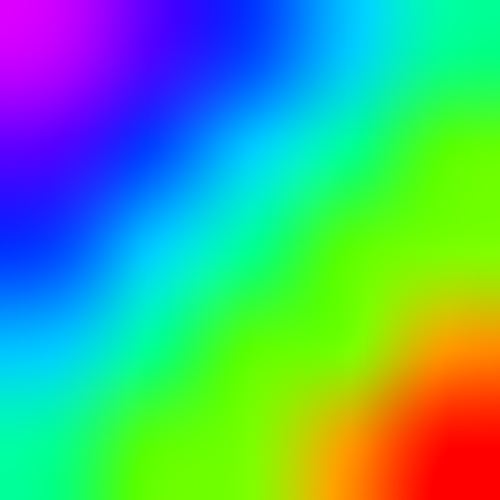
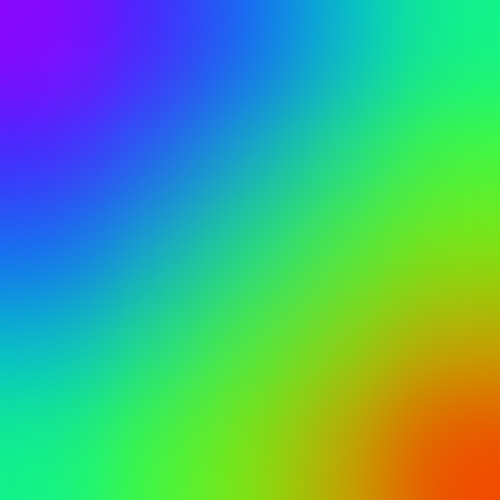
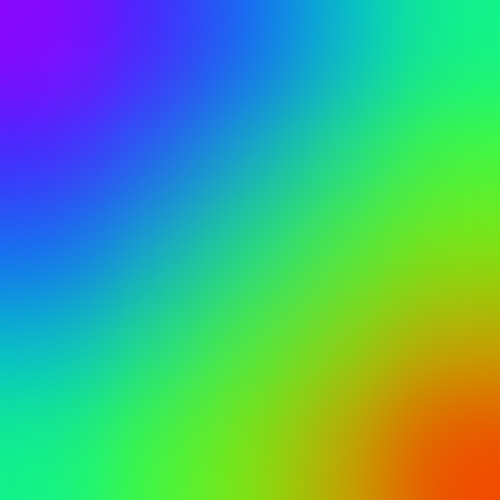


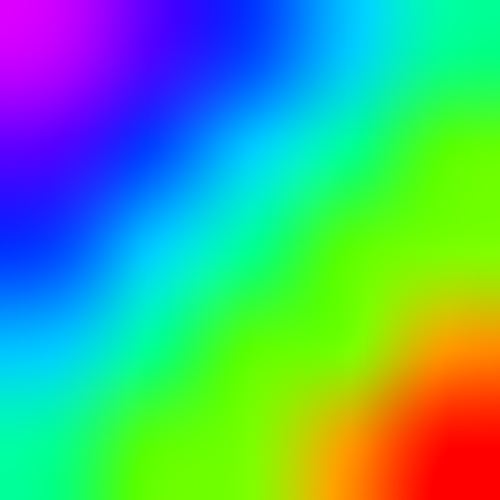
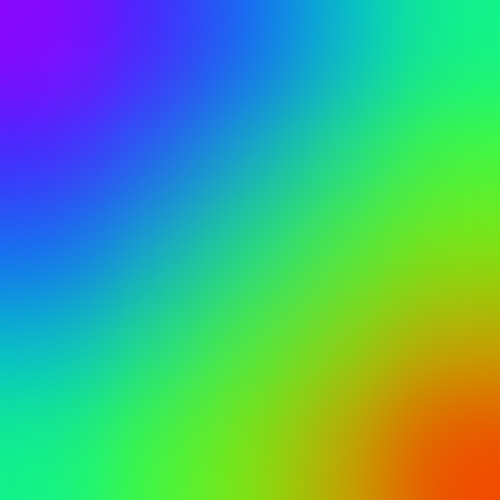
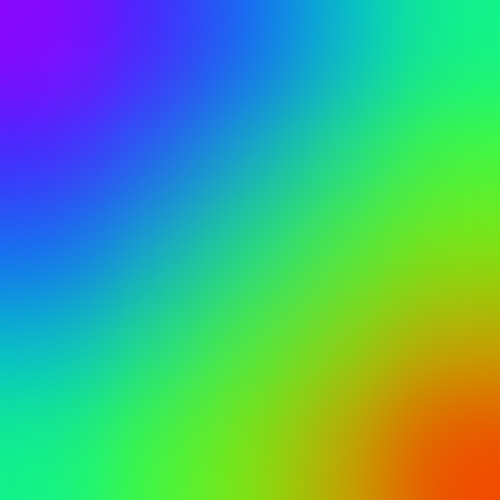


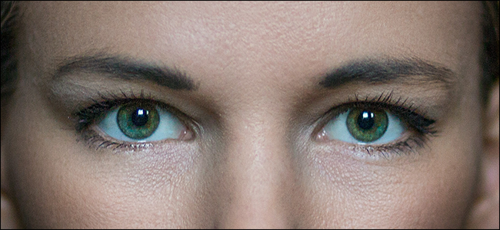
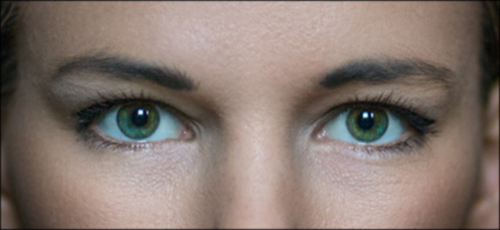
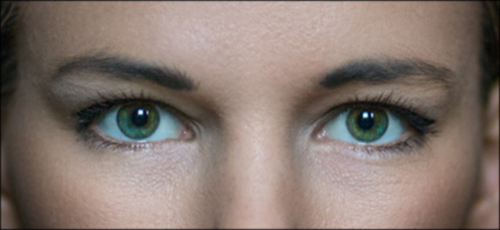


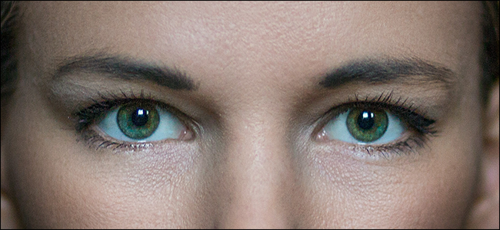
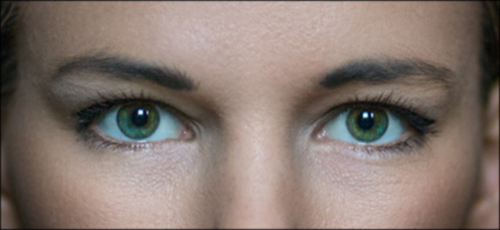
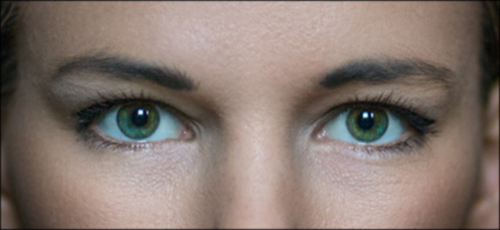


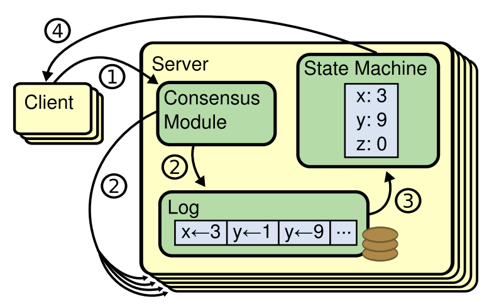
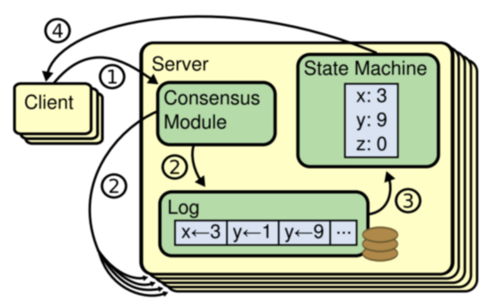
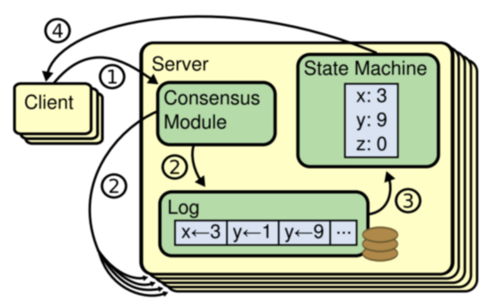


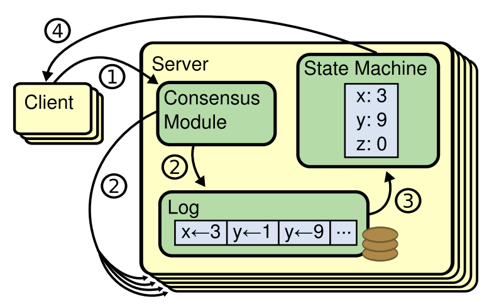
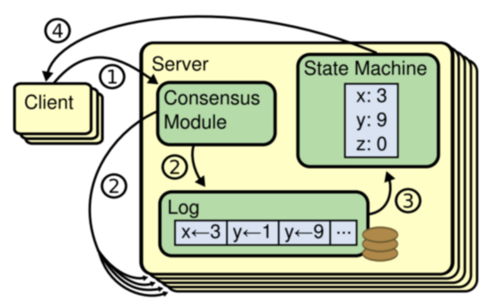
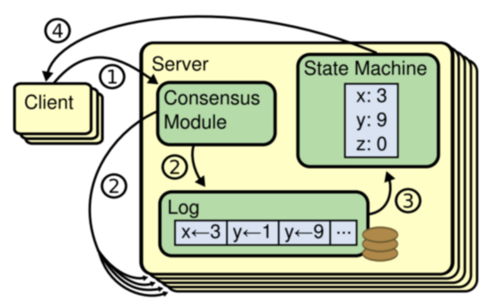


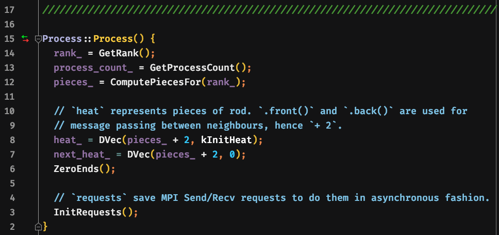
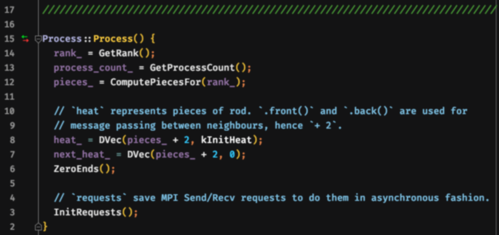
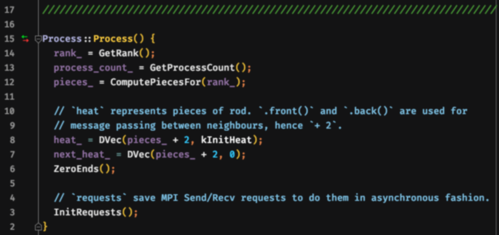


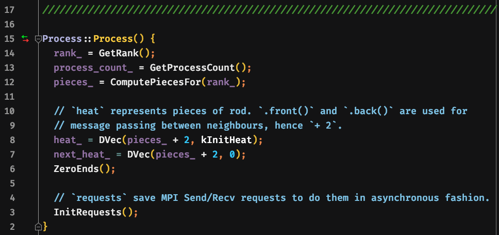
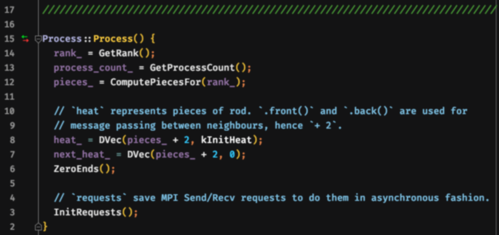
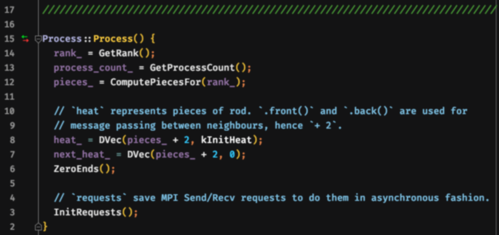

In [10]:
import ipyplot

limit = 4
for image, cpu, gpu in zip(image_paths[:limit], cpu_blurred_paths[:limit], gpu_blurred_paths[:limit]):
    ipyplot.plot_images(
        [image, cpu, gpu],
        img_width=500,
        force_b64=True,
    )

### Plots

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
_ = sns.set()
sns.set_style('darkgrid')

In [12]:
pixels_in_images = [
    get_pixels_in_image(path) / 1000
    for path in image_paths
]

In [18]:
def plot_time(cpu, gpu, kernel):
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("tab10")

    for i, dur in enumerate([cpu, gpu]):
        plt.plot(pixels_in_images, dur, 
                 label="CPU" if i == 0 else "GPU", linewidth=2.5, 
                 marker='o', color=colors[i])

    plt.legend(prop={'size': 12}, loc="best")
    plt.title(f'Blur time for kernel size {kernel}', fontsize=15)
    plt.xlabel('Pixels in image, thousands')
    plt.ylabel('Time taken, milliseconds')
    plt.show()

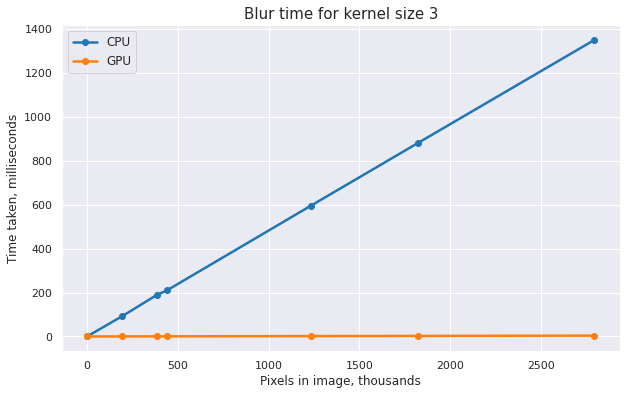

In [19]:
plot_time(
    cpu=[0, 93, 189, 210, 595, 880, 1349],
    gpu=[0.035584, 0.305184, 0.573248, 0.654976, 1.76336, 2.58326, 3.95507],
    kernel=3,
)

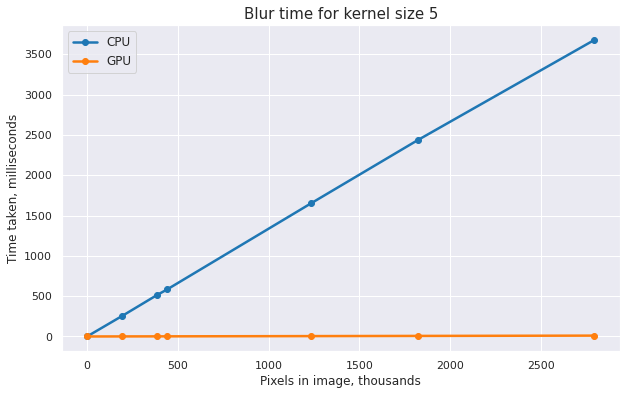

In [20]:
plot_time(
    cpu=[0, 257, 513, 583, 1651, 2437, 3679],
    gpu=[0.045024, 0.774688, 1.50115, 1.72736, 4.68534, 6.89805, 10.5228],
    kernel=5,
)

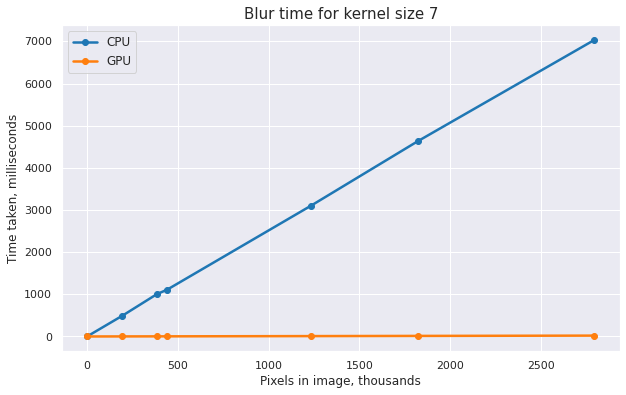

In [21]:
plot_time(
    cpu=[0, 494, 1004, 1109, 3101, 4633, 7034], 
    gpu=[0.065632, 1.48893, 2.89942, 3.32966, 9.06774, 13.35, 20.3732],
    kernel=7,
)

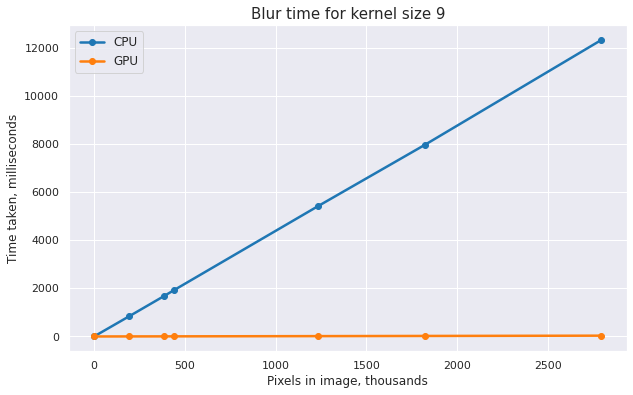

In [22]:
plot_time(
    cpu=[0, 846, 1674, 1925, 5410, 7959, 12315], 
    gpu=[0.085152, 2.43715, 4.7416, 5.44973, 14.891, 21.9442, 33.5258],
    kernel=9,
)